---
layout: post
category: blog
title: "Where do Mayors Come From: Querying Wikidata with Python and SPARQL"
tags: [Wikidata, SPARQL, Python, Pandas, Data Science]
image: /assets/wikidata_mayors_screen.png
---

In this article, we will be going through building queries for Wikidata with Python and SPARQL by taking a look where mayors in Europe are born. This tutorial is building up the knowledge to collect the data responsible for this [interactive visualization](https://janakiev.com/wikidata-mayors/) from the header image which was done with [deck.gl](http://deck.gl/#/).

[Wikidata](https://www.wikidata.org/) is a free and collaborative [Linked Open Data (LOD)](https://en.wikipedia.org/wiki/Linked_data) knowledge base which can be edited by humans and machines. The project started 2012 by the [Wikimedia Foundation](https://foundation.wikimedia.org/wiki/Home) as an effort to centralize interwiki links, infoboxes and enable rich queries. Its ambitious goal is to structure the whole human knowledge in a way that is machine readable and it speaks well to the vision of Tim Berners-Lee in his [TED talk](https://www.youtube.com/watch?v=OM6XIICm_qo) of 2009. Surprisingly, the idea of the [Semantic Web](https://en.wikipedia.org/wiki/Semantic_Web) existed already in 2001 which is comprised of Linked Data. There have been many projects preceding Wikidata. There is [DBpedia](https://en.wikipedia.org/wiki/DBpedia) which is based on the infoboxes in Wikipedia, [Friend of a Friend (FOAF)](https://en.wikipedia.org/wiki/FOAF_(ontology)) which is an ontology to describe relationships in social networks, [GeoNames](https://en.wikipedia.org/wiki/GeoNames) which provides a database with geographical names, [Upper Mapping and Binding Exchange Layer (UMBEL)](https://en.wikipedia.org/wiki/UMBEL) which is a knowledge graph of concepts and entities and a whole set of others, but Wikidata seems to be the most ambitious project between them.

All of the data there is free (under the [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/) aka public domain), while anyone can edit and contribute to it. So it works in a similar way to Wikipedia. On most (if not all) Wikipedia pages, there is a _Wikidata Item_ link to its corresponding item in Wikidata, where you can find the linked information listed. Note that you can still find holes, but as it is a community effort, this is becoming better and growing over time by every contribution. To access the structured data you can query Wikidata by using its [SPARQL endpoint](https://query.wikidata.org/) which enables you to run advanced queries, or by using its [REST API](https://www.wikidata.org/w/api.php).

In this diagram, you can see the structure of a Wikidata item. Each item has a list of [statements](https://www.wikidata.org/wiki/Help:Statements), which are triples in the form `SUBJECT` - `PREDICATE` - `OBJECT` (e.g. Douglas Adams is educated at the St John's College). In Wikidata the subject is referred to as [item](https://www.wikidata.org/wiki/Help:Items) and the predicate is referred to as [property](https://www.wikidata.org/wiki/Help:Properties). Each property has a value, which can be again an item, text, number, date, or GPS coordinates among others. Each value can have additional [qualifiers](https://www.wikidata.org/wiki/Help:Qualifiers) which have additional information with other property-value pairs such as start time. This structure will be important when we start to express queries with SPARQL.

![Wikidata Data Model](assets/wikidata_data_model.png)

image from [SPARQL/WIKIDATA Qualifiers, References and Ranks](https://en.wikibooks.org/wiki/SPARQL/WIKIDATA_Qualifiers,_References_and_Ranks).

Also, all the code for this article and the interactive visualization can be found in this [repository](https://github.com/njanakiev/wikidata-mayors).

# Introducing SPARQL

Before getting to Python we will dissect [SPARQL](https://en.wikipedia.org/wiki/SPARQL) to get comfortable doing some queries. SPARQL is a query language used to retrieve data stored as [RDF](https://en.wikipedia.org/wiki/Resource_Description_Framework) (Resource Description Framework) and it is standardized by the W3C. It is a powerful language to query Linked data and we can also use it to query Wikidata. The syntax is similar to SQL, but it has some differences for people trained in SQL. One key difference is that in SQL you tend to avoid `JOIN` clauses as they can slow down queries, but in SPARQL the queries mostly consist of joins. But hang in there and let's take a look at such a query. In this example, we want to list all countries in the European Union.

```sparql
SELECT ?country ?countryLabel WHERE {
  ?country wdt:P463 wd:Q458.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
```
You can try this query yourself [here](https://query.wikidata.org/#SELECT%20%3Fcountry%20%3FcountryLabel%20WHERE%20%7B%0A%20%20%3Fcountry%20wdt%3AP463%20wd%3AQ458.%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22.%20%0A%20%20%7D%0A%7D). Note that you can test and play with each query at [https://query.wikidata.org/](https://query.wikidata.org/). The editor there offers a handful of useful features. If you hover over the properties and items in the editor you will get information about them and the editor additionally offers autocompletion. You will also find a list of examples which are quite handy when starting fresh.

Starting with the `SELECT` clause, we define the variables we want to get (variables are prefixed with a question mark). Inside the `WHERE` clause, we set restrictions which mostly take the form of the triples we have covered previously. The statement `?country wdt:P463 wd:Q458.` collects all items which have the property [member of (P463)](https://www.wikidata.org/wiki/Property:P463) with object [European Union (Q458)](https://www.wikidata.org/wiki/Q458) into the variable `country`. As you can see, the statements read like a sentence (i.e. country is a member of the European Union). You also notice that there are the prefixes `wd:` and `wdt:`. These denote items with `wd:` and properties with `wdt:`. We will cover more complicated prefixes later on in this tutorial when we will get into the SPARQL data representation. 

Finally, you will see a confusing part `SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }` within the query. This snippet is responsible for retrieving labels for the collected items into an additional variable with `Label` postfix in the specified language (in this case English). In this query, this would be the `countryLabel` variable storing the label for the `country` variable. Note that the label is only retrieved for items that have a label in the particular language selected (in this case `"en"` for English), as there might be items that are not translated into this particular language.

Interesting sidenote: When running the query you will notice [Kingdom of the Netherlands](https://en.wikipedia.org/wiki/Kingdom_of_the_Netherlands) with Wikidata item [Q29999](https://www.wikidata.org/wiki/Q29999) in the list of European countries. Surprisingly, [Netherlands](https://en.wikipedia.org/wiki/Netherlands) ([Q55](https://www.wikidata.org/wiki/Q55)) is a constituent country of the Kingdom of the Netherlands, but it is not a country. It is similar to how England is part of the United Kingdom. This [video](https://www.youtube.com/watch?v=WBcn-lzTJbk) does a great job explaining the situation if you were puzzled.

# Advanced Queries

Let's now explore other properties of the countries we have selected. If you take a look at [Germany (Q183)](https://www.wikidata.org/wiki/Q183), then you can see a whole host of properties like [population (P1082)](https://www.wikidata.org/wiki/Property:P1082), [median income (P3529)](https://www.wikidata.org/wiki/Property:P3529) or even images with the [image (P18)](https://www.wikidata.org/wiki/Property:P18) property. SPARQL enables us to retrieve those too which leads us to the next query.

```sparql
SELECT 
  ?country ?countryLabel ?population ?area ?medianIncome
WHERE {
  ?country wdt:P463 wd:Q458.
  ?country wdt:P1082 ?population.
  ?country wdt:P2046 ?area.
  ?country wdt:P3529 ?medianIncome.
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
```
You can try this query [here](https://query.wikidata.org/#SELECT%20%0A%20%20%3Fcountry%20%3FcountryLabel%20%0A%20%20%3Fcapital%20%3FcapitalLabel%0A%20%20%3Fpopulation%20%3Farea%20%3FmedianIncome%0AWHERE%20%7B%0A%20%20%3Fcountry%20wdt%3AP463%20wd%3AQ458.%0A%20%20%3Fcountry%20wdt%3AP36%20%3Fcapital.%0A%20%20%3Fcountry%20wdt%3AP1082%20%3Fpopulation.%0A%20%20%3Fcountry%20wdt%3AP2046%20%3Farea.%0A%20%20%3Fcountry%20wdt%3AP3529%20%3FmedianIncome.%0A%20%20%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22.%20%7D%0A%7D).

After trying this query you will notice that the list of countries became shorter.  The reason for this is that each country item that has no population, area or median income as a property is ignored by the query. You can imagine those triples also as a filter constraining the triples that only match this query. We can add the `OPTIONAL` clause which will leave those variables empty if the query cannot find triples within this clause.

```sparql
SELECT 
  ?country ?countryLabel ?population ?area ?medianIncome
WHERE {
  ?country wdt:P463 wd:Q458.
  OPTIONAL { ?country wdt:P1082 ?population }
  OPTIONAL { ?country wdt:P2046 ?area }
  OPTIONAL { ?country wdt:P3529 ?medianIncome }
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
```

You can try this query [here](https://query.wikidata.org/#SELECT%20%0A%20%20%3Fcountry%20%3FcountryLabel%20%0A%20%20%3Fcapital%20%3FcapitalLabel%0A%20%20%3Fpopulation%20%3Farea%20%3FmedianIncome%0AWHERE%20%7B%0A%20%20%3Fcountry%20wdt%3AP463%20wd%3AQ458.%0A%20%20%3Fcountry%20wdt%3AP36%20%3Fcapital.%0A%20%20%20%20%0A%20%20OPTIONAL%20%7B%20%3Fcountry%20wdt%3AP1082%20%3Fpopulation%20%7D%0A%20%20OPTIONAL%20%7B%20%3Fcountry%20wdt%3AP2046%20%3Farea%20%7D%0A%20%20OPTIONAL%20%7B%20%3Fcountry%20wdt%3AP3529%20%3FmedianIncome%20%7D%0A%20%20%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22.%20%7D%0A%7D). Now we see in the table that we will find all countries again.

![Query Result](assets/query_result.png)

# SPARQL Data Representation

We continue our journey with a complicated query which we will unpack step by step. Our goal is now to get for all countries, the capital, the population, the mayor, his birthday and finally his birthplace. The query looks like this.

```sparql
SELECT DISTINCT 
  ?country ?countryLabel ?capital ?capitalLabel ?population 
  ?mayor ?mayorLabel ?birth_place ?birth_placeLabel ?birth_date ?age
WHERE {
  # Get all european countries, their capitals and the population of the capital
  ?country wdt:P463 wd:Q458.
  ?country wdt:P36 ?capital.
  OPTIONAL { ?capital wdt:P1082 ?population. }
  
  # Get all mayors without an end date
  ?capital p:P6 ?statement.
  ?statement ps:P6 ?mayor.
  FILTER NOT EXISTS { ?statement pq:P582 ?end_date }
  
  # Get birth place, birth date and age of mayor
  ?mayor wdt:P19 ?birth_place.
  ?mayor wdt:P569 ?birth_date.
  BIND(year(now()) - year(?birth_date) AS ?age)
  
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
  }
}
```
You can try this query [here](https://query.wikidata.org/#SELECT%20DISTINCT%20%0A%20%20%3Fcountry%20%3FcountryLabel%20%3Fcapital%20%3FcapitalLabel%20%3Fpopulation%20%0A%20%20%3Fmayor%20%3FmayorLabel%20%3Fbirth_place%20%3Fbirth_placeLabel%20%3Fbirth_date%20%3Fage%0AWHERE%20%7B%0A%20%20%3Fcountry%20wdt%3AP463%20wd%3AQ458.%0A%20%20%3Fcountry%20wdt%3AP36%20%3Fcapital.%0A%20%20OPTIONAL%20%7B%20%3Fcapital%20wdt%3AP1082%20%3Fpopulation.%20%7D%0A%20%20%0A%20%20%3Fcapital%20p%3AP6%20%3Fstatement.%0A%20%20%3Fstatement%20ps%3AP6%20%3Fmayor.%0A%20%20FILTER%20NOT%20EXISTS%20%7B%20%3Fstatement%20pq%3AP582%20%3Fend_date%20%7D%0A%20%20%20%20%0A%20%20%3Fmayor%20wdt%3AP19%20%3Fbirth_place.%0A%20%20%3Fmayor%20wdt%3AP569%20%3Fbirth_date.%0A%20%20BIND%28year%28now%28%29%29%20-%20year%28%3Fbirth_date%29%20AS%20%3Fage%29%0A%20%20%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22.%20%0A%20%20%7D%0A%7D).

Let's unpack what is happening here. First, we start by getting the capital of the country which we simply get via the [capital (P36)](https://www.wikidata.org/wiki/Property:P36) property. Next, we get to a more complicated part. To understand how to get to the mayor we have to look at the SPARQL Data Representation in this diagram.

![SPARQL data representation](assets/SPARQL_data_representation.png)

image from [SPARQL/WIKIDATA Qualifiers, References and Ranks](https://en.wikibooks.org/wiki/SPARQL/WIKIDATA_Qualifiers,_References_and_Ranks).

This graph of the data representation that you see here shows the ways you can traverse it to get to various pieces of information with SPARQL starting from an item (in the graph shown as `wd:Q1234`). You can see on the left the classical path we took in our previous triples by using the `wdt:` prefix which leads to the value which can be another item, a numeric value (e.g. the population as in one of the previous queries) or various other data types.

If you take a look at an item like [Rome (Q220)](https://www.wikidata.org/wiki/Q220), you will notice that there are various statements for the [head of government (P6)](https://www.wikidata.org/wiki/Property:P6). We want to get the one which has no end date. We can do this by traversing to the statement node with the `p:` prefix and storing it in the `statement` variable. From this variable, we can get the mayor with the `ps:` prefix. We could have done that with `wdt:` as we already have learned but we want to go one step further. We want to get to [end time (P582)](https://www.wikidata.org/wiki/Property:P582) which is stored as a qualifier in the statement. We can traverse to the qualifier with the `pq:` prefix which would give us the end date, but we want mayors without an end date. This can be done by using the `FILTER NOT EXISTS` clause which excludes all triples with statement node that have an end date.

In the final part, we collect the birthplace, the birth date and the age of the mayor. In order to calculate his age, we use the `BIND` expression. This expression can be used to bind some expression to a variable (in our case the age variable). For this expression, we subtract the year of the birth date with the current year. This concludes this query. You can dig deeper in [SPARQL/WIKIDATA Qualifiers, References and Ranks](https://en.wikibooks.org/wiki/SPARQL/WIKIDATA_Qualifiers,_References_and_Ranks) which describes the data representation in further detail.

# Retrieving SPARQL Queries with Python

We have seen how to work with SPARQL and we can also download the resulting tables in the editor, but how do we automate the whole process? We can access the Wikidata SPARQL endpoint also with Python, which enables us to directly load and analyze the data we have queried. To do this, we will employ the [request](http://docs.python-requests.org/en/master/) module which does a great job at doing HTTP requests with all its necessary tooling. We can create the request by adding the query as a parameter as follows.

In [1]:
import requests

url = 'https://query.wikidata.org/sparql'
query = """
SELECT 
  ?countryLabel ?population ?area ?medianIncome ?age
WHERE {
  ?country wdt:P463 wd:Q458.
  OPTIONAL { ?country wdt:P1082 ?population }
  OPTIONAL { ?country wdt:P2046 ?area }
  OPTIONAL { ?country wdt:P3529 ?medianIncome }
  OPTIONAL { ?country wdt:P571 ?inception. 
    BIND(year(now()) - year(?inception) AS ?age)
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""
r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()

We have packed the query in the `query` variable and we need to additionally supply request with the SPARQL endpoint URL which is [https://query.wikidata.org/sparql](https://query.wikidata.org/sparql). We want to use JSON as an output file, so we add this also to our request. The API returns XML as default but supports besides JSON also TSV, CSV and Binary RDF. This request returns a JSON with all the rows collected from the query, which we can use collect the rows into a [Pandas](https://pandas.pydata.org/) DataFrame as follows.

In [2]:
import pandas as pd
from collections import OrderedDict

countries = []
for item in data['results']['bindings']:
    countries.append(OrderedDict({
        'country': item['countryLabel']['value'],
        'population': item['population']['value'],
        'area': item['area']['value'] 
            if 'area' in item else None,
        'medianIncome': item['medianIncome']['value'] 
            if 'medianIncome' in item else None,
        'age': item['age']['value'] 
            if 'age' in item else None}))

df = pd.DataFrame(countries)
df.set_index('country', inplace=True)
df = df.astype({'population': float, 'area': float, 'medianIncome': float, 'age': float})
df.head()

,population,area,medianIncome,age
country,,,,
Kingdom of the Netherlands,17100715.0,42201.0,NaN,207.0
Republic of Ireland,4761865.0,70273.0,25969.0,85.0
Belgium,11431406.0,30528.0,31112.0,192.0
Hungary,9769526.0,93011.4,NaN,1022.0
Spain,46733038.0,505990.0,21959.0,543.0


Let's explore the collected data visually and compare the various properties for each country. 

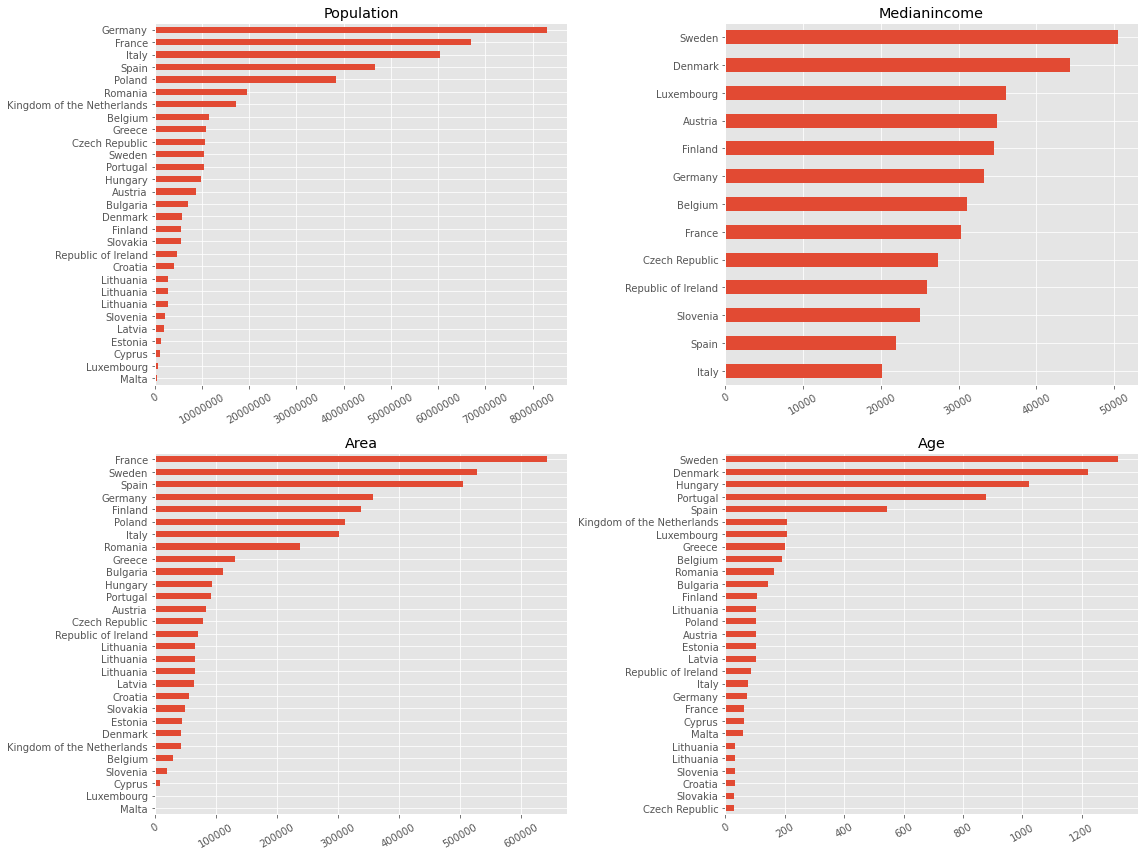

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(16, 12))
for i, label in enumerate(['population', 'medianIncome', 'area', 'age']):
    plt.subplot(2, 2, i + 1)
    df_plot = df[label].sort_values().dropna()
    df_plot.plot(kind='barh', color='C0', ax=plt.gca());
    plt.ylabel('')
    plt.xticks(rotation=30)
    plt.title(label.capitalize())
    plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()

# Mayors of all European Capitals

In our final query, we will take a look at where mayors are born by adding the coordinates to the query. In order to get the latitude and longitude coordinates as variables, we need to add the following snippet.

```sparql
?capital p:P625/psv:P625 ?capital_node.
?capital_node wikibase:geoLatitude ?capital_lat.
?capital_node wikibase:geoLongitude ?capital_lon.
```

In the first line, we traverse the graph of the previously shown data representation. The slash in `p:P625/psv:P625` means that we continue to the _Value node_ of the [coordinate location (P625)](https://www.wikidata.org/wiki/Property:P625) without using a separate variable for the _Statement node_. Then, `wikibase:geoLatitude` and `wikibase:geoLongitude` are responsible for retrieving the latitude and longitude from the _Value node_ respectively. For more information, take a look at [Precision, Units and Coordinates](https://en.wikibooks.org/wiki/SPARQL/WIKIDATA_Precision,_Units_and_Coordinates).

In [4]:
url = 'https://query.wikidata.org/sparql'
query="""
SELECT DISTINCT 
  ?countryLabel ?capitalLabel ?population ?capital_lon ?capital_lat
  ?mayorLabel ?birth_date ?age ?birth_place ?birth_placeLabel ?birth_place_lon ?birth_place_lat
WHERE {
  ?country wdt:P463 wd:Q458.
  ?country wdt:P36 ?capital.
  OPTIONAL { ?capital wdt:P1082 ?population. }
  
  # Get latitude longitude coordinates of capital
  ?capital p:P625/psv:P625 ?capital_node.
  ?capital_node wikibase:geoLatitude ?capital_lat.
  ?capital_node wikibase:geoLongitude ?capital_lon.

  ?capital p:P6 ?statement.
  ?statement ps:P6 ?mayor.
  FILTER NOT EXISTS { ?statement pq:P582 ?end_date }

  ?mayor wdt:P569 ?birth_date.
  BIND(year(now()) - year(?birth_date) AS ?age)
  ?mayor wdt:P19 ?birth_place.
  ?birth_place wdt:P625 ?birth_place_coordinates.
  
  # Get latitude longitude coordinates of birth place
  ?birth_place p:P625/psv:P625 ?birth_place_node.
  ?birth_place_node wikibase:geoLatitude ?birth_place_lat.
  ?birth_place_node wikibase:geoLongitude ?birth_place_lon.
  
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
  }
}
"""

r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()

countries = []
for item in data['results']['bindings']:
    countries.append(OrderedDict({
        label : item[label]['value'] if label in item else None
        for label in ['countryLabel', 'capitalLabel',  'capital_lon', 'capital_lat', 'population', 
                       'mayorLabel', 'birth_date', 'age', 
                       'birth_placeLabel', 'birth_place_lon', 'birth_place_lat']}))

df = pd.DataFrame(countries)
df.set_index('capitalLabel', inplace=True)
df = df.astype({'population': float, 'age': float,
                'capital_lon': float, 'capital_lat': float, 
                'birth_place_lon': float, 'birth_place_lat': float})
df.head()

,countryLabel,capital_lon,capital_lat,population,mayorLabel,birth_date,age,birth_placeLabel,birth_place_lon,birth_place_lat
capitalLabel,,,,,,,,,,
Prague,Czech Republic,14.416667,50.083333,1335084.0,Zdeněk Hřib,1981-05-21T00:00:00Z,41.0,Slavičín,17.873493,49.087984
Sofia,Bulgaria,23.321726,42.697886,1277411.0,Yordanka Fandakova,1962-04-12T00:00:00Z,60.0,Samokov,23.555411,42.337139
City of Brussels,Belgium,4.351667,50.846667,185103.0,Philippe Close,1971-03-18T00:00:00Z,51.0,Namur,4.866667,50.466667
Helsinki,Finland,24.934170,60.175560,642045.0,Juhana Vartiainen,1958-05-28T00:00:00Z,64.0,Helsinki,24.934170,60.175560
Rome,Italy,12.482778,41.893056,2872800.0,Virginia Raggi,1978-07-18T00:00:00Z,44.0,Rome,12.482778,41.893056


Taking this data set we can explore the age of the mayors and the population of the capital they are serving.

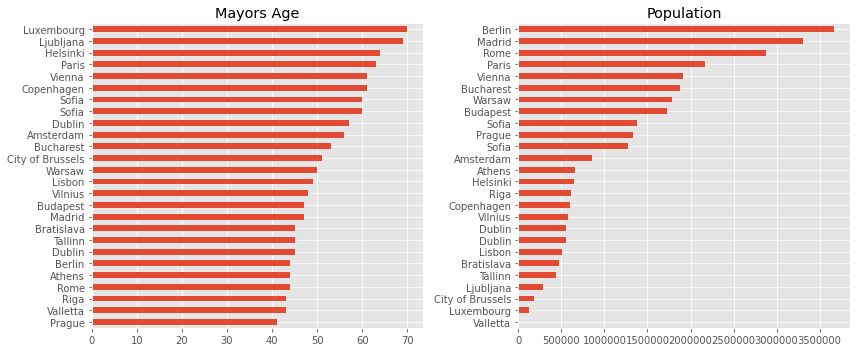

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['age'].sort_values().plot(kind='barh', color='C0', title='Mayors Age')
plt.ylabel('')
plt.subplot(1, 2, 2)
df['population'].sort_values().plot(kind='barh', color='C0', title='Population')
plt.ylabel('')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()

Next, let's take a look at how far mayors are born from the capital. For this, we will use the [geopy](https://geopy.readthedocs.io/en/stable/) package to calculate the distance between the coordinates. This [tutorial](https://janakiev.com/blog/gps-points-distance-python/) covers this topic if you are curious why we can't just use euclidean distance on GPS coordinates.

In [6]:
from geopy.distance import distance

coordinates = df[['capital_lon', 'capital_lat', 'birth_place_lon', 'birth_place_lat']]
df['distance'] = [distance((lat0, lon0), (lat1, lon1)).m 
                for lon0, lat0, lon1, lat1 in coordinates.values]

df['distance'].sort_values().plot(kind='barh', color='C0', logx=True, figsize=(12, 7))
plt.xlabel('Distance (m)')
plt.ylabel('');

ModuleNotFoundError: No module named 'geopy'

Here we can see that most mayors tend to be born in or close to the city where they later serve (note, that the chart is in log-scale). We can see that Athens leads the exceptions with their current mayor (Giorgos Kaminis) born in New York, USA and Paris with their current mayor (Anne Hidalgo) born in San Fernando, Spain. From there the distances drop significantly.

To get a list of all mayors in Europe, take a look at this [script](https://github.com/njanakiev/wikidata-mayors/blob/master/load_european_mayors.py), which is more involved as it has to deal with some exceptions (like mayors born in countries that do not exist anymore) and the queries need to be done for each country separately because there is a limit on the queries. The final interactive visualization can be found [here](https://janakiev.com/wikidata-mayors/) and the complete code including this notebook can be found in this [repository](https://github.com/njanakiev/wikidata-mayors).

# Conclusion

We have learned how to work with Wikidata and SPARQL and also how to integrate it with Python and Pandas.  Wikidata is a great database that enables queries and discoveries that would not be possible with ordinary searches on your favorite search engine. This opens up exciting new possibilities to do data science and exploratory data analysis and a fascinating new way to learn about relationships and curious findings in our accumulated human knowledge.

## Resources and a Pile of Links

A good read covering the history and an overview of Wikidata can be found in the article [Wikidata: a free collaborative knowledge base.](http://delivery.acm.org/10.1145/2630000/2629489/p78-vrandecic.pdf?ip=188.23.116.132&id=2629489&acc=OA&key=4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35%2EB8CD93A2515AABD1&__acm__=1533116941_da1ef0b41c8a6ea97e62187e7e72de90) by Vrandečić, D., & Krötzsch, M. (2014). There is a great [SPARQL tutorial](https://www.wikidata.org/wiki/Wikidata:SPARQL_tutorial) covering many of the things mentioned here and goes into much more depth into understanding SPARQL. If you are excited about Wikidata and want to contribute, there are [Wikidata Tours](https://www.wikidata.org/wiki/Wikidata:Tours) that can guide you through the process. If you plan on doing large queries, make sure to take a look at the publicly downloadable [Wikidata dumps](https://dumps.wikimedia.org/wikidatawiki/entities/) which are regularly updated dumps of the whole Wikidata data set and here is a documentation on the [Wikibase data model](https://www.mediawiki.org/wiki/Wikibase/DataModel). Wikidata provides also a list of [Tools for programmers](https://www.wikidata.org/wiki/Wikidata:Tools/For_programmers).

Here is an unstructured list of resources that contain useful documentation, tutorials or examples that use Wikidata. If you are aware of more useful resources or if you generally have some feedback feel free to contact me or add a push request to the [notebook](https://github.com/njanakiev/wikidata-mayors/blob/master/wikidata-mayors.ipynb) of this article.

- [RDF Exports from Wikidata](https://tools.wmflabs.org/wikidata-exports/rdf/)
- [Wikidata:List of properties](https://www.wikidata.org/wiki/Wikidata:List_of_properties)
- [Wikidata:Database reports](https://www.wikidata.org/wiki/Wikidata:Database_reports)
- [Wikidata:Database reports/List of properties/Top100](https://www.wikidata.org/wiki/Wikidata:Database_reports/List_of_properties/Top100)
- [Wikidata:Introduction](https://www.wikidata.org/wiki/Wikidata:Introduction)
- [Wikidata:SPARQL queries](https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/queries)
- [Wikidata:SPARQL queries examples](https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/queries/examples)
- [Wikidata:Creating a bot](https://www.wikidata.org/wiki/Wikidata:Creating_a_bot)
- [Querying Wikidata About Vienna’s Tram Lines: An Introduction to SPARQL](https://noniq.at/0016/wikidata-sparql-introduction/)
- [How US Presidents Died According to Wikidata](http://ramiro.org/notebook/us-presidents-causes-of-death/)
- [An Ambitious Wikidata Tutorial - SlideShare](https://de.slideshare.net/_Emw/an-ambitious-wikidata-tutorial)
- [Wikidata Graph Builder](https://angryloki.github.io/wikidata-graph-builder/), great tool to visualize Wikidata graphs
- [Histropedia](http://histropedia.com), visualization of historical timelines